In [80]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import random
from preparatory_functions import *
from training_functions import *
from error_functions import *
from autoencoder import AutoEncoder
import torch
import torch.nn as nn 
import logging
import gc
# erase disk memory so we re-train the same each time 
gc.collect()
seed = 100
torch.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [162]:
# load & sample data
dataset_zip = np.load('./dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
imgs_full = dataset_zip['imgs']
sample_imgs = random.sample(list(imgs_full), 1000)
transformed_baseline_imgs = transform_background_colors(sample_imgs)
anomaly_imgs = np.array([create_anomalous_dataset(i) for i in transformed_baseline_imgs])
transformed_images = data_transformations(transformed_baseline_imgs)
transformed_anomaly_images = data_transformations(anomaly_imgs)

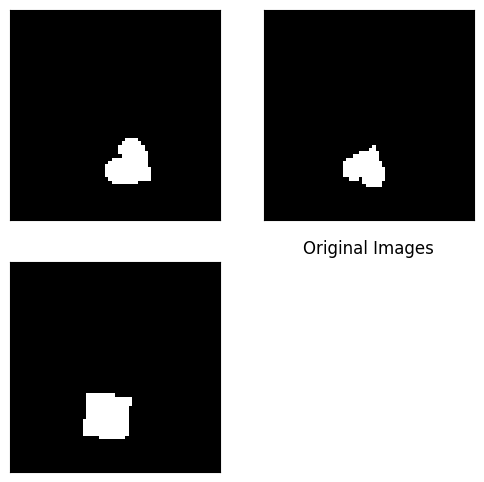

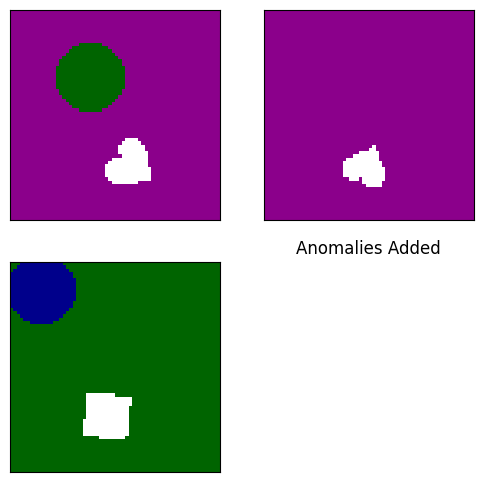

In [163]:
show_images_grid(sample_imgs, 3, title='Original Images')
show_images_grid(anomaly_imgs, 3, title='Anomalies Added')

In [164]:
transformed_anomaly_images[0].shape

torch.Size([3, 64, 64])

In [84]:
def conv_transpose1d_output_size(H_in, stride, padding, dilation, kernel_size, output_padding):
    """
    Compute the output size of a 1D transposed convolution.

    Parameters
    ----------
    H_in : int
        Input size (length).
    stride : int
        Stride of the convolution.
    padding : int
        Padding applied to the input.
    dilation : int
        Dilation factor of the kernel.
    kernel_size : int
        Size of the convolution kernel.
    output_padding : int
        Additional size added to the output shape.

    Returns
    -------
    int
        The computed output size.
    """
    return (H_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

print(conv_transpose1d_output_size(32, 2, 1, 1, 4, 0))

64


In [165]:
data_loaders = torch.utils.data.DataLoader(transformed_images, batch_size=20, shuffle=False)
data_loaders_anomaly = torch.utils.data.DataLoader(transformed_anomaly_images, batch_size=20, shuffle=False)

In [166]:
model = AutoEncoder(channels=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [167]:
logging.info('Training start!')

training_outputs, trained_model = training_loop(epochs=10, data_loader=data_loaders, model=model, criterion=criterion, optimizer=optimizer)




INFO:root:Training start!


Epoch 0 loss: 0.03521846979856491
Epoch 1 loss: 0.003359651193022728
Epoch 2 loss: 0.001631424413062632
Epoch 3 loss: 0.0008919094107113779
Epoch 4 loss: 0.0005763539811596274
Epoch 5 loss: 0.0004105030093342066
Epoch 6 loss: 0.0003108301607426256
Epoch 7 loss: 0.00024616849259473383
Epoch 8 loss: 0.0002037418889813125
Epoch 9 loss: 0.00017335242591798306


In [168]:
predictions = eval_loop(model=trained_model, data_loader=data_loaders)
anomaly_predictions = eval_loop(model=trained_model, data_loader=data_loaders_anomaly)
latent_space_predictions = eval_loop(model=trained_model, data_loader=data_loaders, latent_space=True)
latent_space_predictions_anomaly = eval_loop(model=trained_model, data_loader=data_loaders_anomaly, latent_space=True)


In [187]:
different_heights = np.arange(0.1, 1, 0.1)
kde_results = {}
for h in different_heights:
    average_recond_error, average_density, stdev_recon_error, stdev_density, density_list, recon_error_list = calc_density_and_recon_error(dataloader=data_loaders, 
                                                                                                                                       model=trained_model, 
                                                                                                                                       latent_space_images=latent_space_predictions,
                                                                                                                                       height=h
                                                                                                                                       )
    average_recond_error_anomaly, average_density_anomaly, stdev_recon_error_anomaly, stdev_density_anomaly, density_list_anomaly, recon_error_list_anomaly = calc_density_and_recon_error(dataloader=data_loaders_anomaly, 
                                                                                                                                                                                           model=trained_model, 
                                                                                                                                                                                           latent_space_images=latent_space_predictions_anomaly,
                                                                                                                                                                                           height=h
                                                                                                                                                                                           )
    
    kde_results[f'height_{h}'] = {'average_recond_error_anomaly': average_recond_error_anomaly,
                                  'average_density_anomaly': average_density_anomaly, 
                                  'stdev_recon_error_anomaly': stdev_recon_error_anomaly,
                                  'stdev_density_anomaly': stdev_density_anomaly,
                                  'density_list_anomaly': density_list_anomaly, 
                                  'recon_error_list_anomaly': recon_error_list_anomaly,
                                  'average_recond_error': average_recond_error,
                                  'average_density': average_density, 
                                  'stdev_recon_error': stdev_recon_error,
                                  'stdev_density': stdev_density,
                                  'density_list': density_list, 
                                  'recon_error_list': recon_error_list}



In [189]:
# next steps is to create the for-loop and show the accuracy of the images if they've been detected as anomally or not 
correct = 0
incorrect = 0 
index = 0
error_interval = 0.0005

for h in different_heights:
    anomalies_detected = 0
    anomalies_missed = 0
    normal_image_detected = 0
    normal_image_missed = 0
    # using the average reconstruction error for anomalies you can check whether or not it falls above or below the average error
    for error in kde_results[f'height_{h}']['recon_error_list_anomaly']:
        if error >= average_recond_error_anomaly - error_interval:
            anomalies_detected += 1
            tag = 'anomaly'
        else: 
            anomalies_missed += 1 
            tag = 'non anomaly'


    for error in kde_results[f'height_{h}']['recon_error_list']:
        if error >= average_recond_error_anomaly - error_interval:
            print(error)
            normal_image_missed += 1 
            tag = 'not normal'
        else: 
            normal_image_detected += 1
            tag = 'normal'

    print(f'-----------------results for height {h}-------------------')
    print(f'true positives {normal_image_detected}')
    print(f'false negatives {normal_image_missed}')
    print(f'true negative {anomalies_detected}')
    print(f'false positive {anomalies_missed}')



-----------------results for height 0.1-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.2-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.30000000000000004-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.4-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.5-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.6-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.7000000000000001-------------------
true positives 51
false negatives 0
true negative 50
false positive 1
-----------------results for height 0.8-------------------
true po

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\3009580534.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\3009580534.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


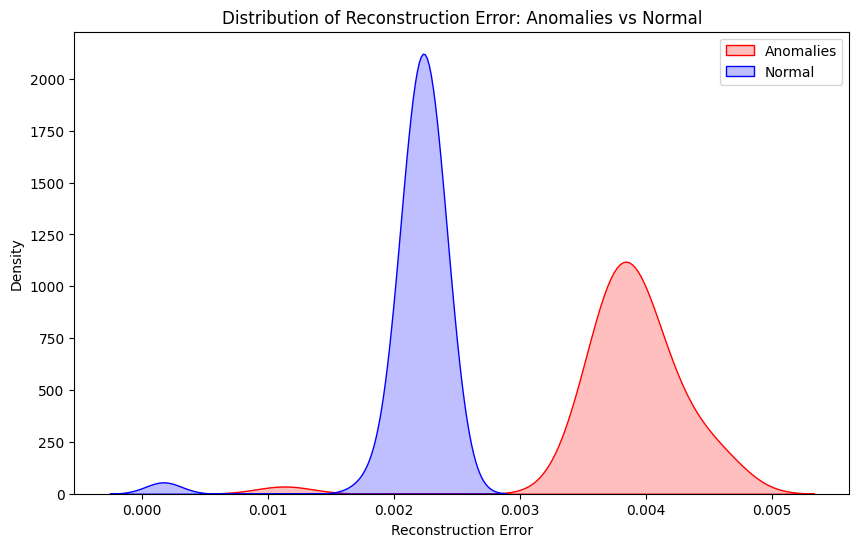

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example lists: replace with your actual data
recon_error_anomalies = kde_results['height_0.1']['recon_error_list_anomaly']
recon_error_normals = kde_results['height_0.1']['recon_error_list']

# Create a figure
plt.figure(figsize=(10, 6))

# Plot KDE for anomalies
sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')

# # Plot KDE for normal images
sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')

# Optionally, also show histograms
# plt.hist(recon_error_anomalies, bins=30, alpha=0.3, color='red')
# plt.hist(recon_error_normals, bins=30, alpha=0.3, color='blue')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Error: Anomalies vs Normal')
plt.legend()

# Show plot
plt.show()


C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


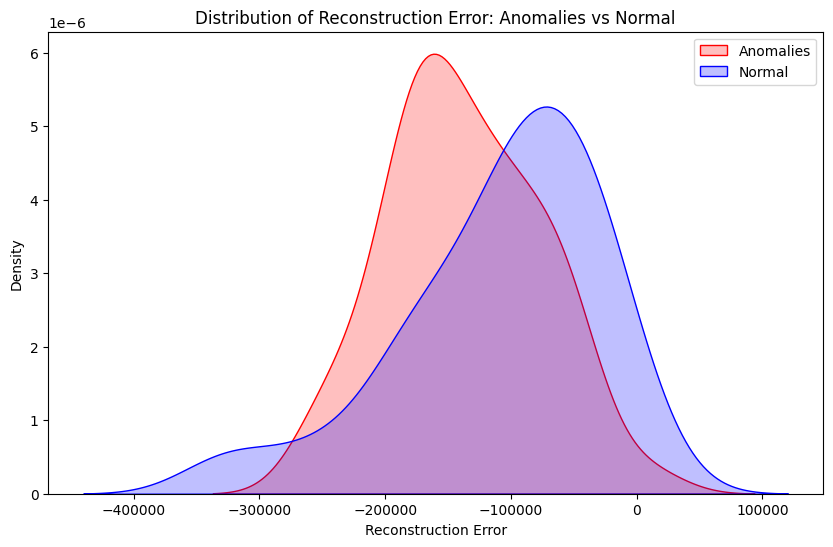

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


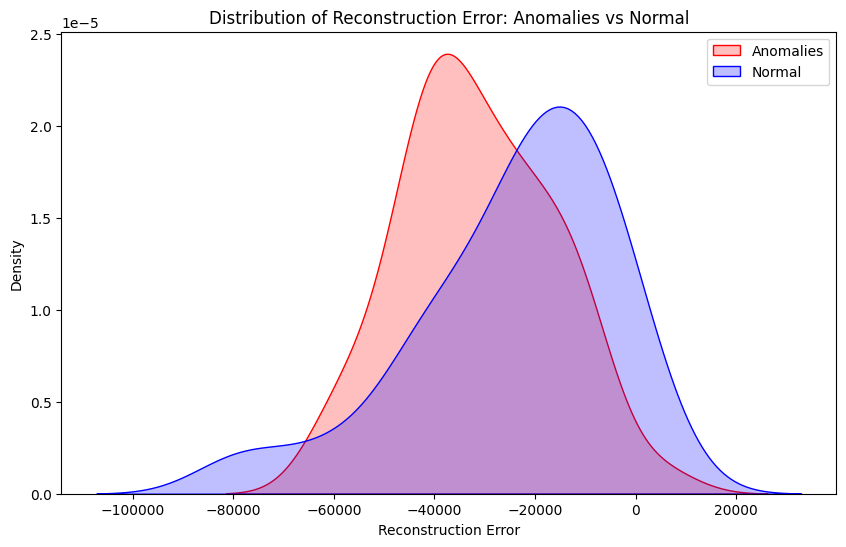

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


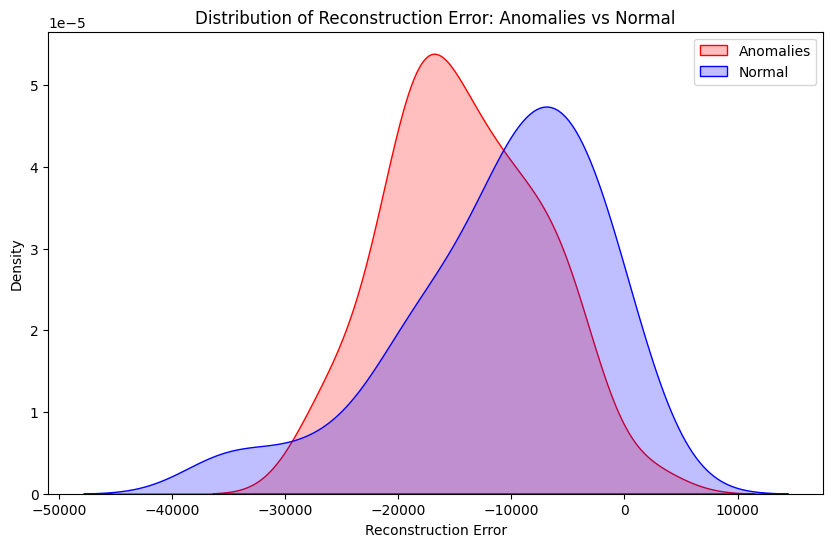

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


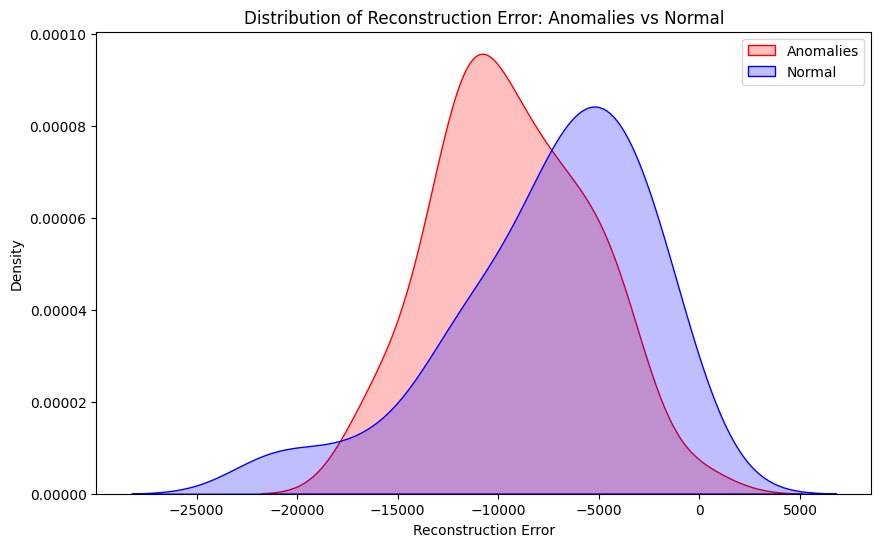

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


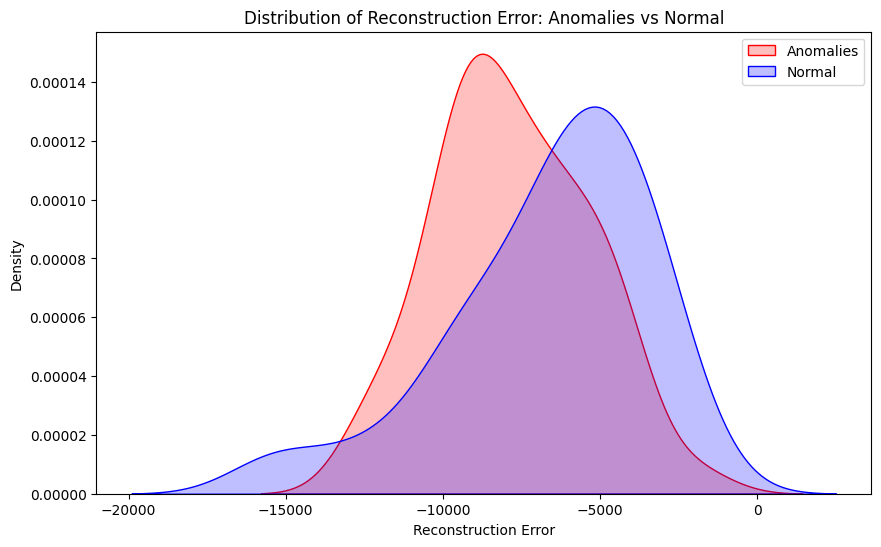

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


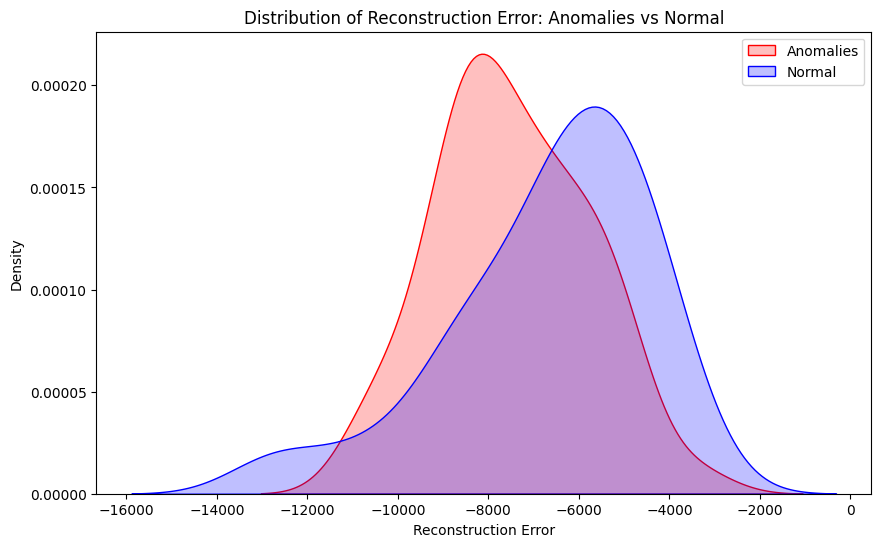

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


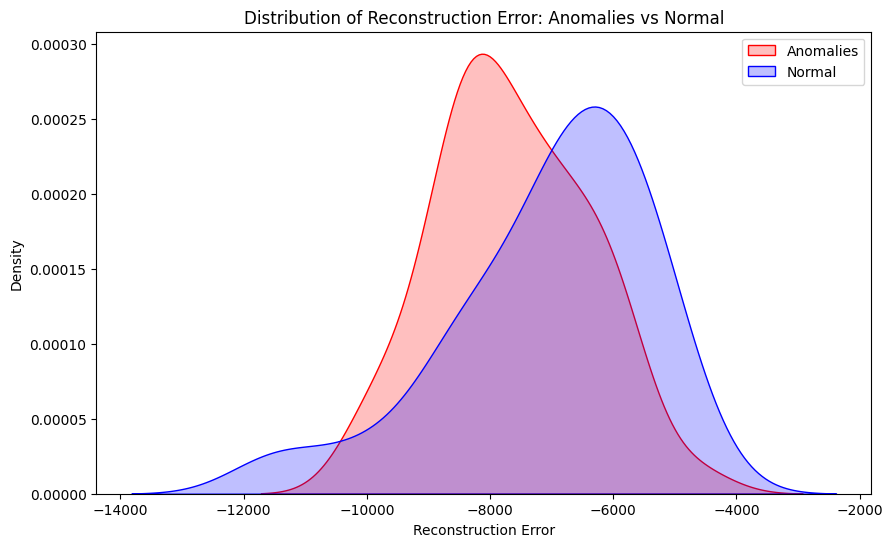

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


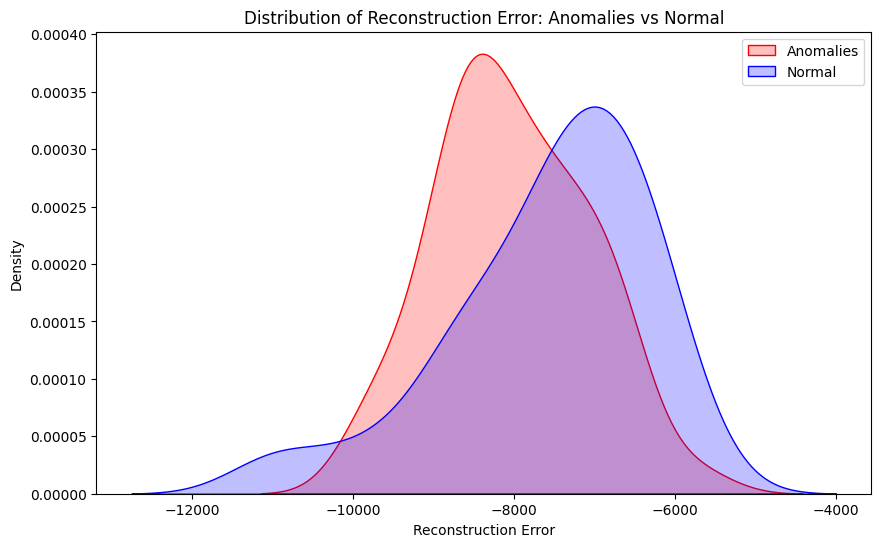

C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\31954255.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


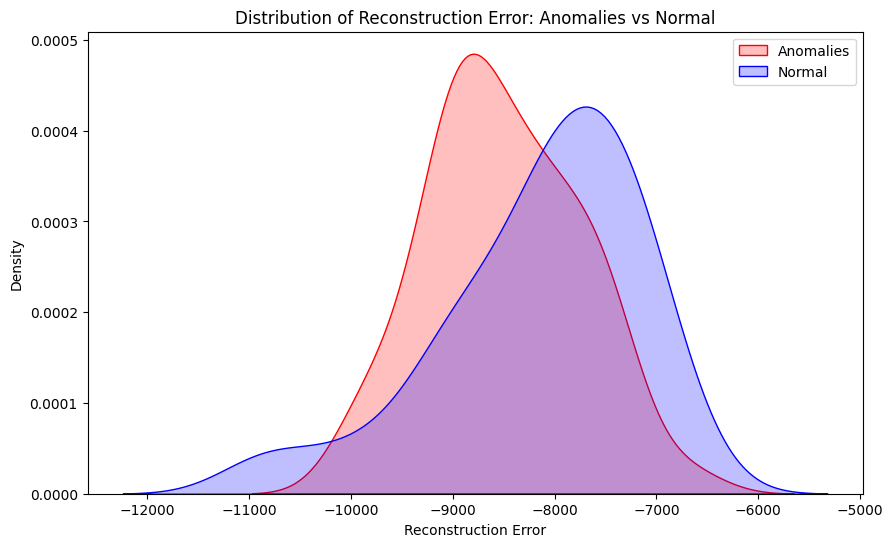

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

for h in different_heights:
# Example lists: replace with your actual data
    recon_error_anomalies = kde_results[f'height_{h}']['density_list_anomaly']
    recon_error_normals = kde_results[f'height_{h}']['density_list']

    # Create a figure
    plt.figure(figsize=(10, 6))

    # Plot KDE for anomalies
    sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')

    # # Plot KDE for normal images
    sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')

    # Optionally, also show histograms
    # plt.hist(recon_error_anomalies, bins=30, alpha=0.3, color='red')
    # plt.hist(recon_error_normals, bins=30, alpha=0.3, color='blue')

    # Add labels and title
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Error: Anomalies vs Normal')
    plt.legend()

    # Show plot
    plt.show()


In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recon_error_distributions(kde_results, different_heights):
    """
    Plots reconstruction error distributions for anomalies vs normal images
    for multiple heights using subplots.

    Args:
        kde_results (dict): dictionary containing 'recon_error_list_anomaly' and 'recon_error_list' for each height
        different_heights (list): list of height values to plot
    """
    n_heights = len(different_heights)
    ncols = 2
    nrows = (n_heights + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))
    axes = axes.flatten()  # flatten in case of single row/column

    for idx, h in enumerate(different_heights):
        ax = axes[idx]
        recon_error_anomalies = kde_results[f'height_{h}']['density_list_anomaly']
        recon_error_normals = kde_results[f'height_{h}']['density_list']

        sns.kdeplot(recon_error_anomalies, shade=True, color='red', alpha=0.4, label='Anomalies', ax=ax)
        sns.kdeplot(recon_error_normals, shade=True, color='blue', alpha=0.4, label='Normal', ax=ax)

        ax.set_xlabel('Reconstruction Error')
        ax.set_ylabel('Density')
        ax.set_title(f'Reconstruction Error Distribution: height {h}')
        ax.legend()

    # Remove empty subplots if number of heights is odd
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\6821003.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', alpha=0.4, label='Anomalies', ax=ax)
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\6821003.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', alpha=0.4, label='Normal', ax=ax)
C:\Users\jonny\AppData\Local\Temp\ipykernel_27236\6821003.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', alpha=0.4, label='Anomalies', ax=ax)
C:\Users\jonny\AppData\Local\Temp\ipykernel_

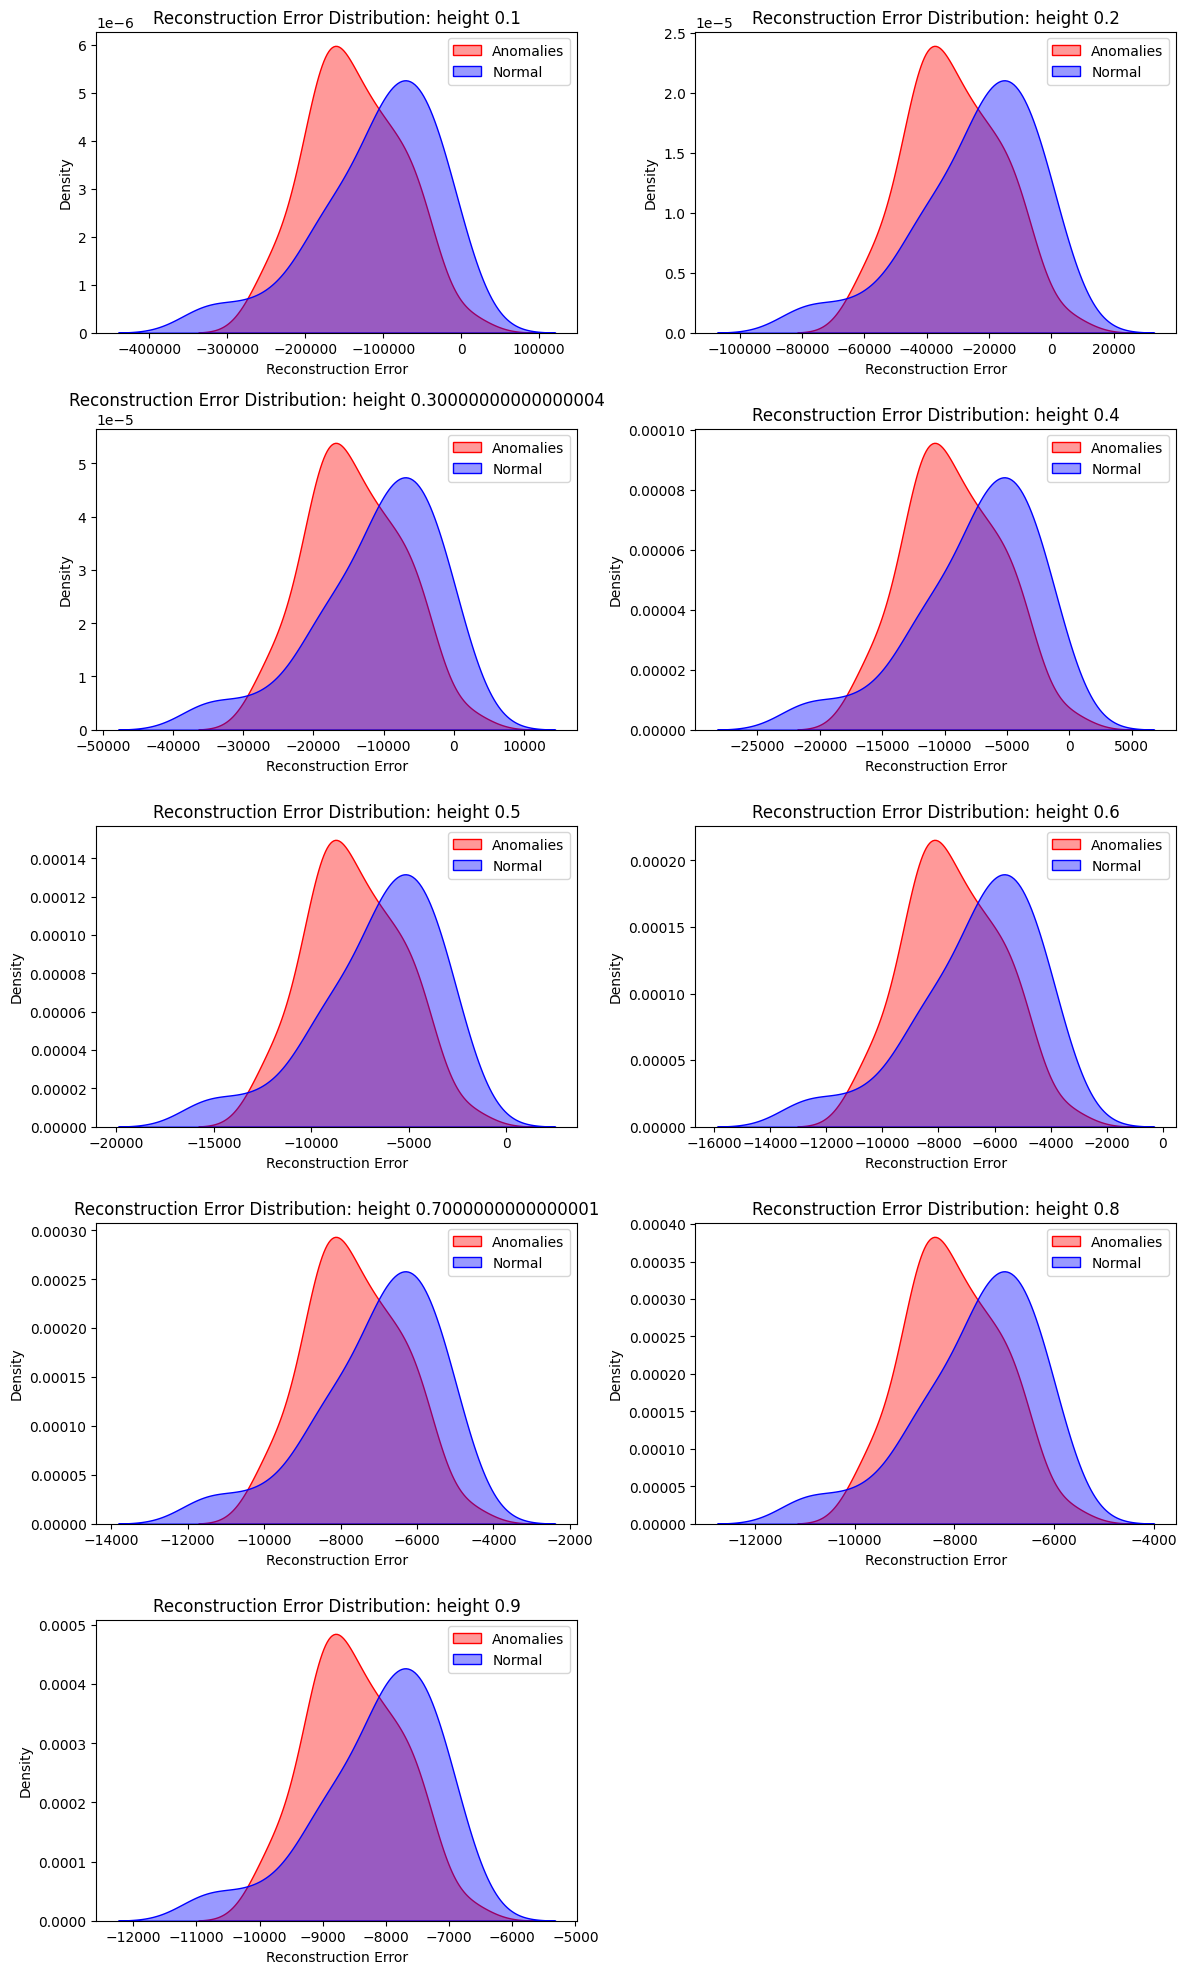

In [198]:
plot_recon_error_distributions(kde_results=kde_results, different_heights=different_heights)

In [ ]:
()

51
51


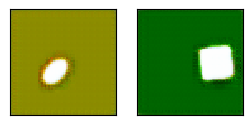

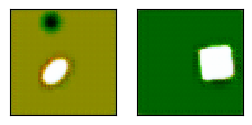

In [160]:
show_images_grid(predictions, 2)
show_images_grid(anomaly_predictions, 2)

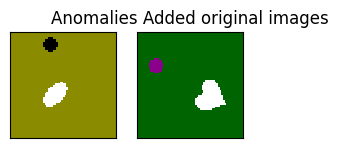

In [117]:
show_images_grid(anomaly_imgs, 2, title='Anomalies Added original images')

In [152]:
kde_results['height_0.1']['average_recond_error_anomaly']

np.float64(0.003076680776133549)

In [131]:
kde_results['height_0.1']['average_recond_error']

np.float64(0.003076680776133549)

In [153]:
predictions[0].mean()

tensor(0.1837)

In [154]:
anomaly_predictions[0].mean()

tensor(0.1858)

In [155]:
anomaly_imgs[0].mean()

np.float64(96.99365234375)